<a href="https://colab.research.google.com/github/erinmcmahon26/NLP-MovieReviews/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries and Ingest Data

In [102]:
import re
import string
import nltk
import gensim
import spacy

import pandas as pd
import numpy as np

import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

from gensim.models import Word2Vec

from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from typing import List, Callable, Dict, Tuple, Set

In [103]:
tf.random.set_seed(2022)

In [104]:
import spacy.cli

spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [105]:
nlp = spacy.load('en_core_web_lg')

In [106]:
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [107]:
corpus=pd.read_csv(r'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_Sec57_2202_ClassCorpus_v2.csv')

In [108]:
corpus.head()

,Doc_ID,DSI_Title,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Text
0,1,EMU_Doc1_TheConjuring3,EMU,Horror,Negative,The Conjuring 3,I must admit that when I sat down to watch the...
1,2,EMU_Doc2_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,While The Conjuring franchise has stood as one...
2,3,EMU_Doc3_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,We’re well into the world and the lore of the ...
3,4,EMU_Doc4_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,James Wan's 2013 feature The Conjuring was som...
4,5,EMU_Doc5_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,Two Conjuring films and several spinoffs estab...


### EDA

In [109]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)
    
def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

In [110]:
corpus['raw_sentences'] = corpus.Text.apply(get_sentences)

In [111]:
corpus.head()

,Doc_ID,DSI_Title,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Text,raw_sentences
0,1,EMU_Doc1_TheConjuring3,EMU,Horror,Negative,The Conjuring 3,I must admit that when I sat down to watch the...,[I must admit that when I sat down to watch th...
1,2,EMU_Doc2_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,While The Conjuring franchise has stood as one...,[While The Conjuring franchise has stood as on...
2,3,EMU_Doc3_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,We’re well into the world and the lore of the ...,[We’re well into the world and the lore of the...
3,4,EMU_Doc4_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,James Wan's 2013 feature The Conjuring was som...,"[James Wan's 2013 feature , The Conjuring was ..."
4,5,EMU_Doc5_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,Two Conjuring films and several spinoffs estab...,[Two Conjuring films and several spinoffs esta...


In [112]:
corpus['Movie Title'].value_counts()

The Conjuring 3                                           10
Mission Impossible Fallout                                10
Encanto                                                   10
Guardians of the Galaxy                                   10
Frozen II                                                 10
Red Notice                                                10
The Ring                                                  10
Arrival                                                   10
Us                                                        10
Spider Man 3                                              10
Hereditary                                                10
The Grand Budapest Hotel                                  10
Pirates of the Caribbean: The Curse of the Black Pearl    10
The Matrix Resurrections                                  10
Cruella                                                   10
Speed Racer                                               10
Lamb                    

In [113]:
# drop duplicates found from last notebook
corpus = corpus.drop(24)
corpus = corpus.drop(42)

In [114]:
fulldata = corpus.copy()

In [115]:
fulldata.head()

,Doc_ID,DSI_Title,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Text,raw_sentences
0,1,EMU_Doc1_TheConjuring3,EMU,Horror,Negative,The Conjuring 3,I must admit that when I sat down to watch the...,[I must admit that when I sat down to watch th...
1,2,EMU_Doc2_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,While The Conjuring franchise has stood as one...,[While The Conjuring franchise has stood as on...
2,3,EMU_Doc3_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,We’re well into the world and the lore of the ...,[We’re well into the world and the lore of the...
3,4,EMU_Doc4_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,James Wan's 2013 feature The Conjuring was som...,"[James Wan's 2013 feature , The Conjuring was ..."
4,5,EMU_Doc5_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,Two Conjuring films and several spinoffs estab...,[Two Conjuring films and several spinoffs esta...


In [116]:
fulldata['clean_text'] = fulldata['Text'].apply(lambda x : clean_doc(x))


In [117]:
fulldata['clean_text'][0]

"I must admit I sat watch 2021 addition `` The Conjuring '' franchise , I harboring much overly great expectation hope , since first movie steady downward slope . Still , I chance sit watch `` The Conjuring : The Devil Made Me Do It '' writer David Leslie Johnson-McGoldrick James Wan . So course I . And I say director Michael Chaves managed deliver movie slightly entertaining . `` The Conjuring : The Devil Made Me Do It '' whole lot nothing going , essentially watch beginning last 25 minute movie skip everything . The storyline written `` The Conjuring : The Devil Made Me Do It '' bland slow paced , little much excitement interest happening start end movie . And ultimately led le mediocre movie experience . And yeah , I horror veteran , `` The Conjuring : The Devil Made Me Do It '' walk park . There jump scare moment , could seen coming mile away . And storyline n't particularly dark , brooding scary . So impressive foray horror genre . I say special effect `` The Conjuring : The Devil

#### Genre EDA

In [118]:
genre_data = fulldata[['Text', 'Genre of Movie']]

In [119]:
genre_data.head()

,Text,Genre of Movie
0,I must admit that when I sat down to watch the...,Horror
1,While The Conjuring franchise has stood as one...,Horror
2,We’re well into the world and the lore of the ...,Horror
3,James Wan's 2013 feature The Conjuring was som...,Horror
4,Two Conjuring films and several spinoffs estab...,Horror


In [120]:
genre_data['Genre of Movie'] = genre_data['Genre of Movie'].astype("category")
genre_data['genre_code'] = genre_data['Genre of Movie'].cat.codes
genre_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Text,Genre of Movie,genre_code
0,I must admit that when I sat down to watch the...,Horror,2
1,While The Conjuring franchise has stood as one...,Horror,2
2,We’re well into the world and the lore of the ...,Horror,2
3,James Wan's 2013 feature The Conjuring was som...,Horror,2
4,Two Conjuring films and several spinoffs estab...,Horror,2


In [121]:
genre_data[['Genre of Movie', 'genre_code']].value_counts()

Genre of Movie  genre_code
Comedy          1             60
Horror          2             49
Sci-Fi          3             49
Action          0             40
dtype: int64

In [122]:
features, targets = genre_data['Text'], genre_data['genre_code']

In [123]:
train_features, test_features, train_targets, test_targets = train_test_split(features, 
                                                                              targets , 
                                                                              test_size=0.20, 
                                                                              random_state=42, 
                                                                              shuffle=True,
                                                                              stratify=targets)

In [124]:
trainds, valds, testds = get_dataset_partitions_pd(genre_data[['Text','genre_code']])
trainds.shape, valds.shape, testds.shape

((158, 2), (20, 2), (20, 2))

In [125]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['genre_code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['genre_code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['genre_code'].values, tf.int64),
)

In [126]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

In [127]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size = train_ds.cardinality().numpy()

train_ds = (train_ds.shuffle(buffer_size=buffer_size)
                    .batch(batch_size=batch_size,drop_remainder=True)
                    .cache()
                    .prefetch(AUTOTUNE))

test_ds = (test_ds.shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size,drop_remainder=True)
                  .cache()
                  .prefetch(AUTOTUNE))

val_ds = (val_ds.shuffle(buffer_size=buffer_size)
                .batch(batch_size=batch_size,drop_remainder=True)
                .cache()
                .prefetch(AUTOTUNE))

In [128]:
x_train = train_features.to_numpy()
y_train = train_targets.to_numpy()
x_test = test_features.to_numpy()
y_test = test_targets.to_numpy()

In [129]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

#### Sentiment (positive and negative reviews) EDA

In [130]:
sentiment_data = fulldata[['Review Type (pos or neg)', 'Text']]

In [131]:
sentiment_data['Review Type (pos or neg)'] = sentiment_data['Review Type (pos or neg)'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [132]:
sentiment_data['Review Type (pos or neg)'].value_counts()

negative    100
positive     98
Name: Review Type (pos or neg), dtype: int64

In [133]:
sentiment_data['Review Type (pos or neg)'] = sentiment_data['Review Type (pos or neg)'].astype("category")
sentiment_data['sentiment_code'] = sentiment_data['Review Type (pos or neg)'].cat.codes
sentiment_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Review Type (pos or neg),Text,sentiment_code
0,negative,I must admit that when I sat down to watch the...,0
1,positive,While The Conjuring franchise has stood as one...,1
2,positive,We’re well into the world and the lore of the ...,1
3,positive,James Wan's 2013 feature The Conjuring was som...,1
4,positive,Two Conjuring films and several spinoffs estab...,1


In [134]:
sentiment_data['sentiment_code'].value_counts()

0    100
1     98
Name: sentiment_code, dtype: int64

In [135]:
sfeatures, stargets = sentiment_data['Text'], sentiment_data['sentiment_code']

In [136]:
strain_features, stest_features, strain_targets, stest_targets = train_test_split(sfeatures, 
                                                                              stargets , 
                                                                              test_size=0.20, 
                                                                              random_state=42, 
                                                                              shuffle=True,
                                                                              stratify=stargets)

In [137]:
strainds, svalds, stestds = get_dataset_partitions_pd(sentiment_data[['Text','sentiment_code']])
strainds.shape, svalds.shape, stestds.shape

((158, 2), (20, 2), (20, 2))

In [138]:
# train X & y
strain_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(strainds['Text'].values, tf.string)
) 
strain_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(strainds['sentiment_code'].values, tf.int64),
  ) 
# test X & y
stest_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(stestds['Text'].values, tf.string)
) 
stest_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(stestds['sentiment_code'].values, tf.int64),
)
#val X & Y
sval_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(svalds['Text'].values, tf.string)
) 
sval_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(svalds['sentiment_code'].values, tf.int64),
)

In [139]:
strain_ds = tf.data.Dataset.zip(
    (
            strain_text_ds_raw,
            strain_cat_ds_raw
     )
)
stest_ds = tf.data.Dataset.zip(
    (
            stest_text_ds_raw,
            stest_cat_ds_raw
     )
)
sval_ds = tf.data.Dataset.zip(
    (
            sval_text_ds_raw,
            sval_cat_ds_raw
     )
)

In [140]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
sbuffer_size = strain_ds.cardinality().numpy()

strain_ds = (strain_ds.shuffle(buffer_size=sbuffer_size)
                    .batch(batch_size=batch_size,drop_remainder=True)
                    .cache()
                    .prefetch(AUTOTUNE))

stest_ds = (stest_ds.shuffle(buffer_size=sbuffer_size)
                  .batch(batch_size=batch_size,drop_remainder=True)
                  .cache()
                  .prefetch(AUTOTUNE))

sval_ds = (sval_ds.shuffle(buffer_size=sbuffer_size)
                .batch(batch_size=batch_size,drop_remainder=True)
                .cache()
                .prefetch(AUTOTUNE))

In [141]:
sx_train = strain_features.to_numpy()
sy_train = strain_targets.to_numpy()
sx_test = stest_features.to_numpy()
sy_test = stest_targets.to_numpy()

In [142]:
VOCAB_SIZE = 5000
sencoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
sencoder.adapt(strain_ds.map(lambda text, label: text), batch_size= None)

### Modeling to select genre

#### LSTM 1

In [143]:
num_classes = 4

In [144]:
model_1 = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(num_classes, activation='softmax')])

In [145]:
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional_14 (Bidirecti  (None, None, 128)        98816     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                      

In [146]:
model_1.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [147]:
%%time
history = model_1.fit(train_ds
         ,epochs=20
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/20
52/52 [==============================] - 28s 239ms/step - loss: 1.3912 - accuracy: 0.2692 - val_loss: 1.3754 - val_accuracy: 0.3333
Epoch 2/20
52/52 [==============================] - 7s 136ms/step - loss: 1.2775 - accuracy: 0.4423 - val_loss: 1.4395 - val_accuracy: 0.3333
Epoch 3/20
52/52 [==============================] - 7s 135ms/step - loss: 0.7883 - accuracy: 0.6859 - val_loss: 1.0714 - val_accuracy: 0.4444
Epoch 4/20
52/52 [==============================] - 7s 135ms/step - loss: 0.7718 - accuracy: 0.7756 - val_loss: 1.4104 - val_accuracy: 0.6667
Epoch 5/20
52/52 [==============================] - 8s 155ms/step - loss: 0.2980 - accuracy: 0.8910 - val_loss: 1.2971 - val_accuracy: 0.5556
Epoch 6/20
52/52 [==============================] - 7s 138ms/step - loss: 0.0502 - accuracy: 1.0000 - val_loss: 2.1108 - val_accuracy: 0.3333
CPU times: user 1min 6s, sys: 1.9 s, total: 1min 8s
Wall time: 1min 13s


In [148]:
test_loss, test_acc = model_1.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 71ms/step - loss: 1.4930 - accuracy: 0.6111
Test Loss: 1.4929779767990112
Test Accuracy: 0.6111111044883728


In [149]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [150]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,1.278,0.442,1.440,0.333
2,0.788,0.686,1.071,0.444
3,0.772,0.776,1.410,0.667
4,0.298,0.891,1.297,0.556
5,0.050,1.000,2.111,0.333


In [151]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

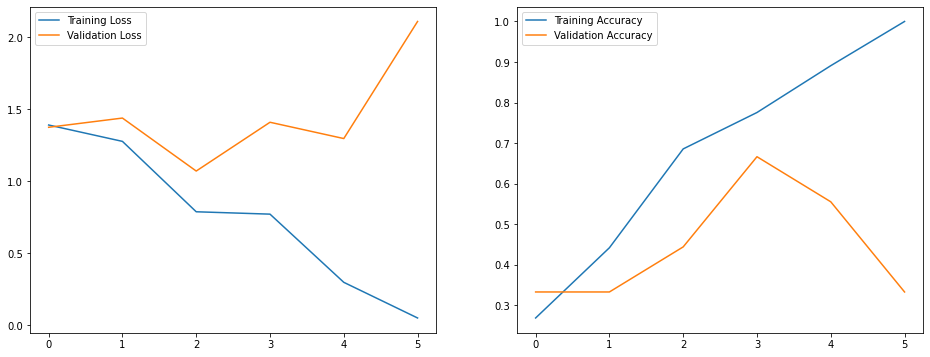

In [152]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [153]:
preds = model_1.predict(test_ds)
y_pred = np.argmax(preds, axis=1)
y_1 = np.concatenate([y for x, y in test_ds], axis=0)

In [154]:
CLASSES_LIST = ['Action', 'Comedy', 'Horror', 'Sci-Fi']

In [155]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

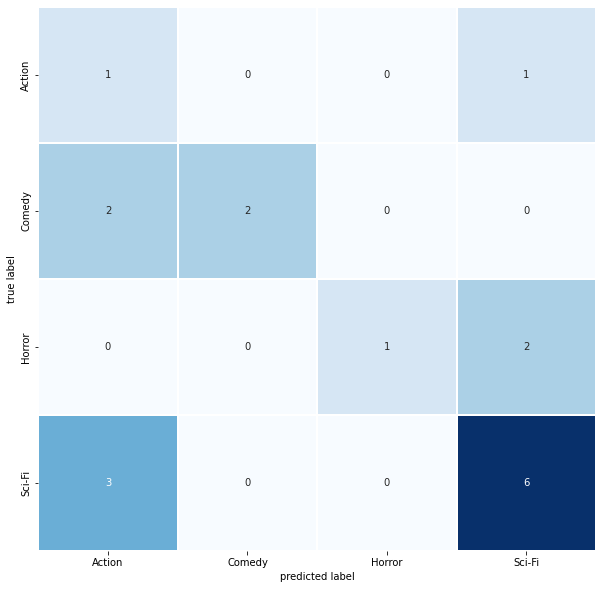

In [156]:
plot_confusion_matrix_labeled(y_1, y_pred, CLASSES_LIST=CLASSES_LIST)

#### LSTM 2

In [157]:
model_2 = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 300, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3)),
                             tf.keras.layers.Dense(300, activation='relu'),
                             tf.keras.layers.Dense(num_classes, activation='softmax')])

In [158]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, None, 300)         1500000   
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 256)        439296    
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 64)               73984     
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 300)               19500     
                                                      

In [159]:
model_2.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [160]:
%%time
history_2 = model_2.fit(train_ds
         ,epochs=20
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/20
52/52 [==============================] - 31s 248ms/step - loss: 1.3935 - accuracy: 0.2564 - val_loss: 1.3507 - val_accuracy: 0.4444
Epoch 2/20
52/52 [==============================] - 8s 148ms/step - loss: 1.1380 - accuracy: 0.5128 - val_loss: 1.0094 - val_accuracy: 0.4444
Epoch 3/20
52/52 [==============================] - 8s 149ms/step - loss: 0.6303 - accuracy: 0.8718 - val_loss: 1.1410 - val_accuracy: 0.5556
Epoch 4/20
52/52 [==============================] - 8s 147ms/step - loss: 0.1585 - accuracy: 0.9487 - val_loss: 1.6793 - val_accuracy: 0.5556
Epoch 5/20
52/52 [==============================] - 8s 148ms/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 1.0168 - val_accuracy: 0.6667
Epoch 6/20
52/52 [==============================] - 8s 150ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.8251 - val_accuracy: 0.7778
Epoch 7/20
52/52 [==============================] - 8s 147ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8866 - val_accuracy: 0.7778
Epoch

In [161]:
test_loss, test_acc = model_2.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 66ms/step - loss: 0.9554 - accuracy: 0.6667
Test Loss: 0.9553947448730469
Test Accuracy: 0.6666666865348816


In [162]:
preds2 = model_2.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

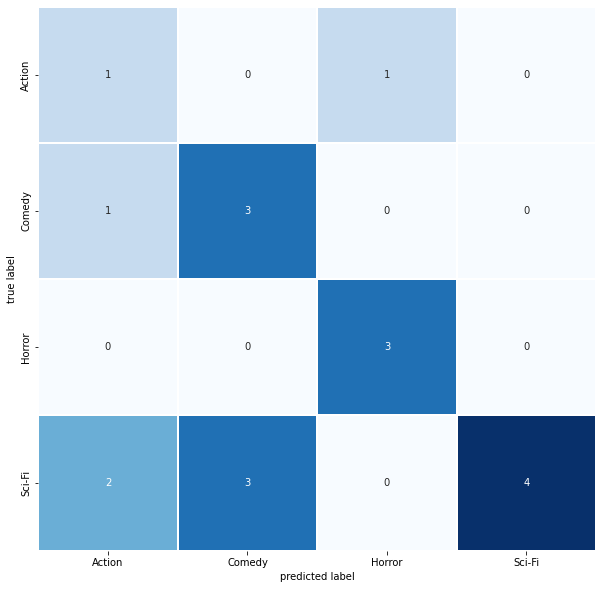

In [163]:
plot_confusion_matrix_labeled(y2, y_pred2, CLASSES_LIST=CLASSES_LIST)

#### LSTM 3

In [164]:
model_3 = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 500, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3)),
                             tf.keras.layers.Dense(500, activation='relu'),
                             tf.keras.layers.Dense(num_classes, activation='softmax')])

In [165]:
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, None, 500)         2500000   
                                                                 
 bidirectional_18 (Bidirecti  (None, None, 400)        1121600   
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 64)               110848    
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 500)               32500     
                                                      

In [166]:
model_3.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [167]:
%%time
history_3 = model_3.fit(train_ds
         ,epochs=20
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/20
52/52 [==============================] - 28s 245ms/step - loss: 1.3963 - accuracy: 0.3141 - val_loss: 1.3515 - val_accuracy: 0.4444
Epoch 2/20
52/52 [==============================] - 8s 148ms/step - loss: 1.0983 - accuracy: 0.5769 - val_loss: 0.7400 - val_accuracy: 0.7778
Epoch 3/20
52/52 [==============================] - 8s 147ms/step - loss: 0.5675 - accuracy: 0.7821 - val_loss: 0.8906 - val_accuracy: 0.6667
Epoch 4/20
52/52 [==============================] - 8s 149ms/step - loss: 0.2260 - accuracy: 0.9359 - val_loss: 0.9488 - val_accuracy: 0.7778
CPU times: user 52.6 s, sys: 1.35 s, total: 54 s
Wall time: 53.3 s


In [168]:
test_loss, test_acc = model_3.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 72ms/step - loss: 1.1707 - accuracy: 0.6111
Test Loss: 1.1707282066345215
Test Accuracy: 0.6111111044883728


In [169]:
preds3 = model_3.predict(test_ds)
y_pred3 = np.argmax(preds3, axis=1)
y3 = np.concatenate([y for x, y in test_ds], axis=0)

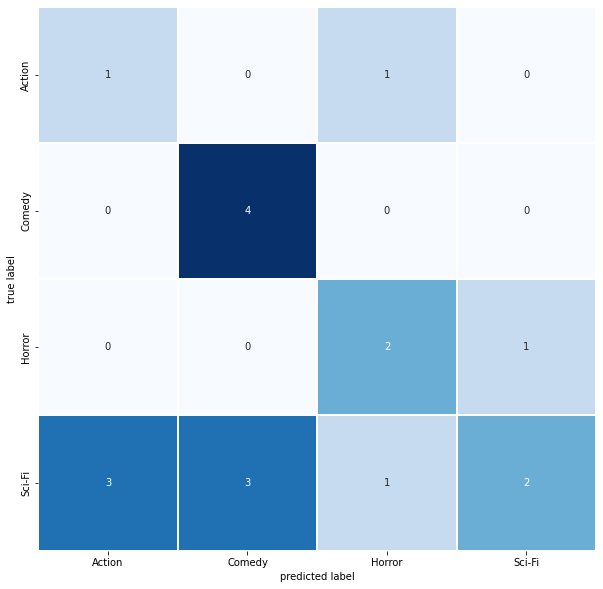

In [170]:
plot_confusion_matrix_labeled(y3, y_pred3, CLASSES_LIST=CLASSES_LIST)

### Modeling to select sentiment (positive or negative reviews)

#### LSTM 1

In [171]:
sent_model_1 = tf.keras.Sequential([sencoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

In [172]:
sent_model_1.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())

In [173]:
#%%time
shistory = sent_model_1.fit(strain_ds
         ,epochs=20
         ,validation_data=sval_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=2)])

Epoch 1/20
52/52 [==============================] - 36s 255ms/step - loss: 0.6965 - binary_accuracy: 0.4231 - val_loss: 0.6930 - val_binary_accuracy: 0.4444
Epoch 2/20
52/52 [==============================] - 9s 172ms/step - loss: 0.6810 - binary_accuracy: 0.6218 - val_loss: 0.9633 - val_binary_accuracy: 0.3333
Epoch 3/20
52/52 [==============================] - 10s 183ms/step - loss: 0.5225 - binary_accuracy: 0.7949 - val_loss: 2.4402 - val_binary_accuracy: 0.4444
Epoch 4/20
52/52 [==============================] - 11s 216ms/step - loss: 0.0919 - binary_accuracy: 0.9872 - val_loss: 0.9251 - val_binary_accuracy: 0.6667
Epoch 5/20
52/52 [==============================] - 11s 210ms/step - loss: 0.0084 - binary_accuracy: 1.0000 - val_loss: 0.0340 - val_binary_accuracy: 1.0000
Epoch 6/20
52/52 [==============================] - 7s 135ms/step - loss: 0.0026 - binary_accuracy: 1.0000 - val_loss: 0.6687 - val_binary_accuracy: 0.8889
Epoch 7/20
52/52 [==============================] - 7s 135ms

In [174]:
test_loss, test_acc = sent_model_1.evaluate(sval_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 96ms/step - loss: 1.7094 - binary_accuracy: 0.7222
Test Loss: 1.7094335556030273
Test Accuracy: 0.7222222089767456


In [175]:
spreds = sent_model_1.predict(stest_ds)
sy_pred = (spreds > 0.5).astype("int32")
sy_1 = np.concatenate([y for x, y in stest_ds], axis=0)

In [176]:
CLASS_LIST = ['Pos', 'Neg']

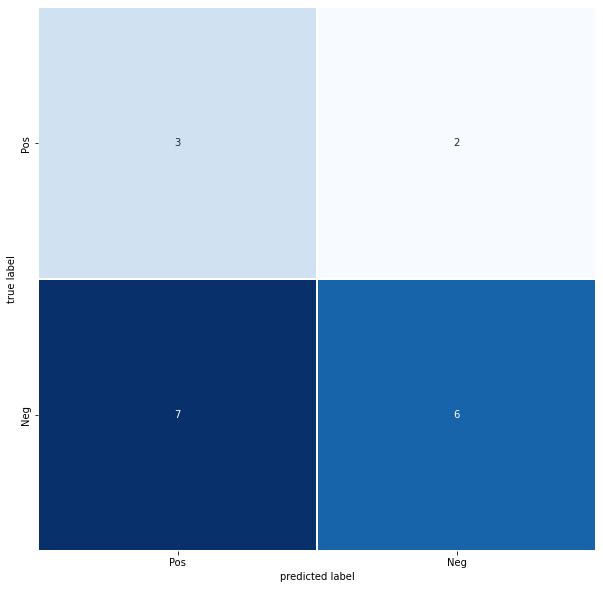

In [177]:
plot_confusion_matrix_labeled(sy_1, sy_pred, CLASSES_LIST=CLASS_LIST)

#### LSTM 2

In [178]:
sent_model_2 = tf.keras.Sequential([sencoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 300, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3)),
                             tf.keras.layers.Dense(300, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

In [179]:
sent_model_2.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())

In [180]:
%%time
shistory_2 = sent_model_2.fit(strain_ds
         ,epochs=20
         ,validation_data=sval_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=2)])

Epoch 1/20
52/52 [==============================] - 28s 245ms/step - loss: 0.6984 - binary_accuracy: 0.4423 - val_loss: 0.6913 - val_binary_accuracy: 0.6667
Epoch 2/20
52/52 [==============================] - 8s 145ms/step - loss: 0.6218 - binary_accuracy: 0.7051 - val_loss: 0.4565 - val_binary_accuracy: 0.7778
Epoch 3/20
52/52 [==============================] - 7s 144ms/step - loss: 0.3633 - binary_accuracy: 0.8269 - val_loss: 0.2031 - val_binary_accuracy: 1.0000
Epoch 4/20
52/52 [==============================] - 7s 144ms/step - loss: 0.0197 - binary_accuracy: 1.0000 - val_loss: 0.4058 - val_binary_accuracy: 0.7778
Epoch 5/20
52/52 [==============================] - 8s 162ms/step - loss: 0.0014 - binary_accuracy: 1.0000 - val_loss: 0.3653 - val_binary_accuracy: 0.7778
Epoch 6/20
52/52 [==============================] - 8s 161ms/step - loss: 3.6036e-04 - binary_accuracy: 1.0000 - val_loss: 0.3771 - val_binary_accuracy: 0.7778
CPU times: user 1min 8s, sys: 1.74 s, total: 1min 10s
Wall 

In [181]:
test_loss, test_acc = sent_model_2.evaluate(sval_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 93ms/step - loss: 0.9060 - binary_accuracy: 0.6111
Test Loss: 0.9059933423995972
Test Accuracy: 0.6111111044883728


In [182]:
spreds2 = sent_model_2.predict(stest_ds)
sy_pred2 = (spreds2 > 0.5).astype("int32")
sy2 = np.concatenate([y for x, y in stest_ds], axis=0)

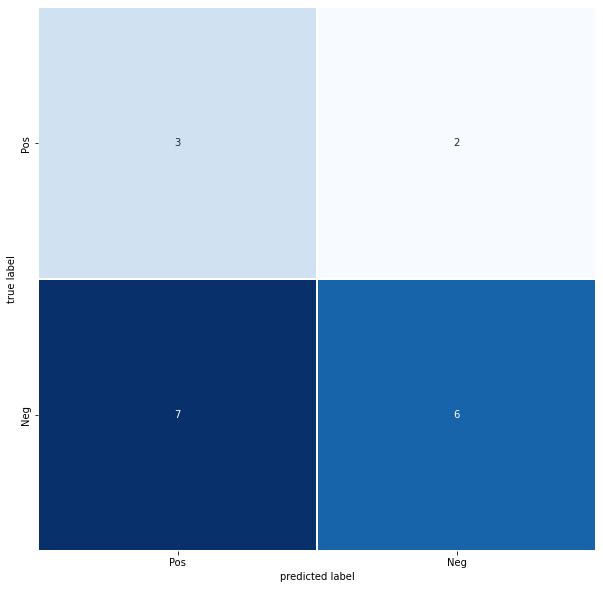

In [183]:
plot_confusion_matrix_labeled(sy2, sy_pred2, CLASSES_LIST=CLASS_LIST)

#### LSTM 3

In [184]:
sent_model_3 = tf.keras.Sequential([sencoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 500, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3)),
                             tf.keras.layers.Dense(500, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

In [185]:
sent_model_3.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())

In [186]:
%%time
shistory_3 = sent_model_3.fit(strain_ds
         ,epochs=20
         ,validation_data=sval_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=2)])

Epoch 1/20
52/52 [==============================] - 30s 245ms/step - loss: 0.7017 - binary_accuracy: 0.4615 - val_loss: 0.6854 - val_binary_accuracy: 0.5556
Epoch 2/20
52/52 [==============================] - 8s 146ms/step - loss: 0.5907 - binary_accuracy: 0.7756 - val_loss: 0.3711 - val_binary_accuracy: 0.8889
Epoch 3/20
52/52 [==============================] - 8s 148ms/step - loss: 0.2911 - binary_accuracy: 0.8910 - val_loss: 0.1999 - val_binary_accuracy: 0.8889
Epoch 4/20
52/52 [==============================] - 8s 147ms/step - loss: 0.0419 - binary_accuracy: 0.9872 - val_loss: 0.0946 - val_binary_accuracy: 1.0000
Epoch 5/20
52/52 [==============================] - 8s 146ms/step - loss: 0.0070 - binary_accuracy: 1.0000 - val_loss: 1.2794 - val_binary_accuracy: 0.6667
Epoch 6/20
52/52 [==============================] - 8s 148ms/step - loss: 9.7464e-04 - binary_accuracy: 1.0000 - val_loss: 1.2647 - val_binary_accuracy: 0.6667
Epoch 7/20
52/52 [==============================] - 8s 146m

In [146]:
test_loss, test_acc = sent_model_3.evaluate(sval_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 5s 868ms/step - loss: 2.3901 - binary_accuracy: 0.5556
Test Loss: 2.3900980949401855
Test Accuracy: 0.5555555820465088


In [147]:
spreds3 = sent_model_3.predict(stest_ds)
sy_pred3 = (spreds3 > 0.5).astype("int32")
sy3 = np.concatenate([y for x, y in stest_ds], axis=0)

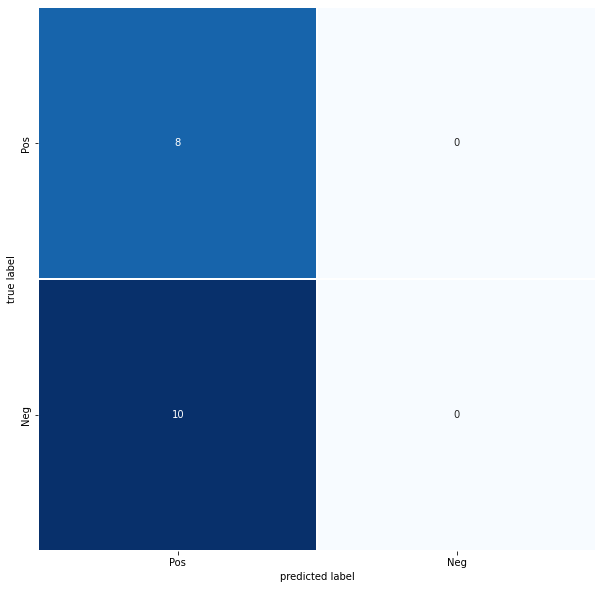

In [148]:
plot_confusion_matrix_labeled(sy3, sy_pred3, CLASSES_LIST=CLASS_LIST)